In [ ]:
# default_exp preprocessing

# Preprocessing

> Este modulo es el encargado de la carga, preprocesamiento y preparacion de los datos.

## Imports

In [ ]:
#hide
from nbdev.showdoc import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from obspy import read
from pathlib import Path
import obspy as op
from functools import lru_cache

## Validacion de archivos

In [ ]:
#export
def check_files(folder_path, station="B2DF", channel="001"):
    freq_setted = False
    freq = -1
    data_list = list()
    f_ok = 0
    f_fail = 0

    for idx, file_path in enumerate(folder_path.glob("**/*")):
        try:
            print(f"File #{idx + 1}: {file_path.name}")
            try:
                data = TimeSerie.load_data_one_file(file_path, station, channel)
            except Exception as e:
                print(e)
                print (f"File: {file_path.name} is not in miniseed format.")
            if not freq_setted:
                freq = data['freq']
            else:
                assert data['freq'] == freq, \
                        f"La frecuencia de las mediciones en los datos es de {data['freq']} \
                        pero se espera una frecuencia igual a {freq}"
            assert 3590 < data['end']-data['start'] < 3600, \
                    f"El archivo debe tener 1 hora de mediciones."
            assert data['freq']*(data['end']-data['start'])+1 == len(data['data']), \
                    f"La cantidad de muestras en los datos no coincide con la frecuencia y tiempo en que se tomaron."
            print(f"File OK!!!")
            f_ok += 1
        except Exception as e:
            print(e)
            print(f"############# File FAILED #############")
            f_fail += 1
    print(f"Files OK: {f_ok} | Files FAILED: {f_fail}")

In [ ]:
#hide
check_files(Path("D:/UCN/2019/Volcanes/deepwave/data/B2DF/raw")) 

File #1: 2018-10-30-2100-00M.B2DF__001_00_01
File OK!!!
File #2: 2018-10-30-2200-00M.B2DF__001_00_01
File OK!!!
File #3: 2018-10-30-2300-00M.B2DF__001_00_01
File OK!!!
File #4: 2018-10-31-0000-00M.B2DF__001_00_01
File OK!!!
File #5: 2018-10-31-0100-07M.B2DF__001_00_01
File OK!!!
File #6: 2018-10-31-0200-07M.B2DF__001_00_01
File OK!!!
File #7: 2018-10-31-0300-00M.B2DF__001_00_01
File OK!!!
File #8: 2018-10-31-0400-08M.B2DF__001_00_01
File OK!!!
File #9: 2018-10-31-0500-00M.B2DF__001_00_01
File OK!!!
File #10: 2018-10-31-0600-00M.B2DF__001_00_01
File OK!!!
File #11: 2018-10-31-0700-08M.B2DF__001_00_01
File OK!!!
File #12: 2018-10-31-0800-08M.B2DF__001_00_01
File OK!!!
File #13: 2018-10-31-0900-00M.B2DF__001_00_01
File OK!!!
File #14: 2018-10-31-1000-00M.B2DF__001_00_01
File OK!!!
File #15: 2018-10-31-1100-00M.B2DF__001_00_01
File OK!!!
File #16: 2018-10-31-1200-00M.B2DF__001_00_01
File OK!!!
File #17: 2018-10-31-1300-00M.B2DF__001_00_01
File OK!!!
File #18: 2018-10-31-1400-05M.B2DF__001_

File OK!!!
File #146: 2018-11-05-2200-00M.B2DF__001_00_01
File OK!!!
File #147: 2018-11-05-2300-00M.B2DF__001_00_01
File OK!!!
File #148: 2018-11-06-0000-00M.B2DF__001_00_01
File OK!!!
File #149: 2018-11-06-0100-08M.B2DF__001_00_01
File OK!!!
File #150: 2018-11-06-0200-07M.B2DF__001_00_01
File OK!!!
File #151: 2018-11-06-0300-00M.B2DF__001_00_01
File OK!!!
File #152: 2018-11-06-0400-07M.B2DF__001_00_01
File OK!!!
File #153: 2018-11-06-0500-00M.B2DF__001_00_01
File OK!!!
File #154: 2018-11-06-0600-00M.B2DF__001_00_01
File OK!!!
File #155: 2018-11-06-0700-07M.B2DF__001_00_01
File OK!!!
File #156: 2018-11-06-0800-07M.B2DF__001_00_01
File OK!!!
File #157: 2018-11-06-0900-00M.B2DF__001_00_01
File OK!!!
File #158: 2018-11-06-1000-00M.B2DF__001_00_01
File OK!!!
File #159: 2018-11-06-1100-00M.B2DF__001_00_01
File OK!!!
File #160: 2018-11-06-1200-00M.B2DF__001_00_01
File OK!!!
File #161: 2018-11-06-1300-00M.B2DF__001_00_01
File OK!!!
File #162: 2018-11-06-1400-07M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #289: 2018-11-11-2100-00M.B2DF__001_00_01
File OK!!!
File #290: 2018-11-11-2200-00M.B2DF__001_00_01
File OK!!!
File #291: 2018-11-11-2300-00M.B2DF__001_00_01
File OK!!!
File #292: 2018-11-12-0000-00M.B2DF__001_00_01
File OK!!!
File #293: 2018-11-12-0100-08M.B2DF__001_00_01
File OK!!!
File #294: 2018-11-12-0200-08M.B2DF__001_00_01
File OK!!!
File #295: 2018-11-12-0300-00M.B2DF__001_00_01
File OK!!!
File #296: 2018-11-12-0400-08M.B2DF__001_00_01
File OK!!!
File #297: 2018-11-12-0500-00M.B2DF__001_00_01
File OK!!!
File #298: 2018-11-12-0600-00M.B2DF__001_00_01
File OK!!!
File #299: 2018-11-12-0700-08M.B2DF__001_00_01
File OK!!!
File #300: 2018-11-12-0800-08M.B2DF__001_00_01
File OK!!!
File #301: 2018-11-12-0900-00M.B2DF__001_00_01
File OK!!!
File #302: 2018-11-12-1000-00M.B2DF__001_00_01
File OK!!!
File #303: 2018-11-12-1100-00M.B2DF__001_00_01
File OK!!!
File #304: 2018-11-12-1200-00M.B2DF__001_00_01
File OK!!!
File #305: 2018-11-12-1300-00M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #437: 2018-11-18-0100-07M.B2DF__001_00_01
File OK!!!
File #438: 2018-11-18-0200-08M.B2DF__001_00_01
File OK!!!
File #439: 2018-11-18-0300-00M.B2DF__001_00_01
File OK!!!
File #440: 2018-11-18-0400-07M.B2DF__001_00_01
File OK!!!
File #441: 2018-11-18-0500-00M.B2DF__001_00_01
File OK!!!
File #442: 2018-11-18-0600-00M.B2DF__001_00_01
File OK!!!
File #443: 2018-11-18-0700-07M.B2DF__001_00_01
File OK!!!
File #444: 2018-11-18-0800-07M.B2DF__001_00_01
File OK!!!
File #445: 2018-11-18-0900-00M.B2DF__001_00_01
File OK!!!
File #446: 2018-11-18-1000-00M.B2DF__001_00_01
File OK!!!
File #447: 2018-11-18-1100-00M.B2DF__001_00_01
File OK!!!
File #448: 2018-11-18-1200-00M.B2DF__001_00_01
File OK!!!
File #449: 2018-11-18-1300-00M.B2DF__001_00_01
File OK!!!
File #450: 2018-11-18-1400-06M.B2DF__001_00_01
File OK!!!
File #451: 2018-11-18-1500-06M.B2DF__001_00_01
File OK!!!
File #452: 2018-11-18-1600-06M.B2DF__001_00_01
File OK!!!
File #453: 2018-11-18-1700-00M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #579: 2018-11-23-2300-00M.B2DF__001_00_01
File OK!!!
File #580: 2018-11-24-0000-00M.B2DF__001_00_01
File OK!!!
File #581: 2018-11-24-0100-07M.B2DF__001_00_01
File OK!!!
File #582: 2018-11-24-0200-08M.B2DF__001_00_01
File OK!!!
File #583: 2018-11-24-0300-00M.B2DF__001_00_01
File OK!!!
File #584: 2018-11-24-0400-07M.B2DF__001_00_01
File OK!!!
File #585: 2018-11-24-0500-00M.B2DF__001_00_01
File OK!!!
File #586: 2018-11-24-0600-00M.B2DF__001_00_01
File OK!!!
File #587: 2018-11-24-0700-08M.B2DF__001_00_01
File OK!!!
File #588: 2018-11-24-0800-08M.B2DF__001_00_01
File OK!!!
File #589: 2018-11-24-0900-00M.B2DF__001_00_01
File OK!!!
File #590: 2018-11-24-1000-00M.B2DF__001_00_01
File OK!!!
File #591: 2018-11-24-1100-00M.B2DF__001_00_01
File OK!!!
File #592: 2018-11-24-1200-00M.B2DF__001_00_01
File OK!!!
File #593: 2018-11-24-1300-00M.B2DF__001_00_01
File OK!!!
File #594: 2018-11-24-1400-06M.B2DF__001_00_01
File OK!!!
File #595: 2018-11-24-1500-05M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #722: 2018-11-29-2200-00M.B2DF__001_00_01
File OK!!!
File #723: 2018-11-29-2300-00M.B2DF__001_00_01
File OK!!!
File #724: 2018-11-30-0000-00M.B2DF__001_00_01
File OK!!!
File #725: 2018-11-30-0100-08M.B2DF__001_00_01
File OK!!!
File #726: 2018-11-30-0200-07M.B2DF__001_00_01
File OK!!!
File #727: 2018-11-30-0300-00M.B2DF__001_00_01
File OK!!!
File #728: 2018-11-30-0400-08M.B2DF__001_00_01
File OK!!!
File #729: 2018-11-30-0500-00M.B2DF__001_00_01
File OK!!!
File #730: 2018-11-30-0600-00M.B2DF__001_00_01
File OK!!!
File #731: 2018-11-30-0700-08M.B2DF__001_00_01
File OK!!!
File #732: 2018-11-30-0800-08M.B2DF__001_00_01
File OK!!!
File #733: 2018-11-30-0900-00M.B2DF__001_00_01
File OK!!!
File #734: 2018-11-30-1000-00M.B2DF__001_00_01
File OK!!!
File #735: 2018-11-30-1100-00M.B2DF__001_00_01
File OK!!!
File #736: 2018-11-30-1200-00M.B2DF__001_00_01
File OK!!!
File #737: 2018-11-30-1300-00M.B2DF__001_00_01
File OK!!!
File #738: 2018-11-30-1400-05M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #866: 2018-12-05-2200-00M.B2DF__001_00_01
File OK!!!
File #867: 2018-12-05-2300-00M.B2DF__001_00_01
File OK!!!
File #868: 2018-12-06-0000-00M.B2DF__001_00_01
File OK!!!
File #869: 2018-12-06-0100-08M.B2DF__001_00_01
File OK!!!
File #870: 2018-12-06-0200-08M.B2DF__001_00_01
File OK!!!
File #871: 2018-12-06-0300-00M.B2DF__001_00_01
File OK!!!
File #872: 2018-12-06-0400-07M.B2DF__001_00_01
File OK!!!
File #873: 2018-12-06-0500-00M.B2DF__001_00_01
File OK!!!
File #874: 2018-12-06-0600-00M.B2DF__001_00_01
File OK!!!
File #875: 2018-12-06-0700-08M.B2DF__001_00_01
File OK!!!
File #876: 2018-12-06-0800-08M.B2DF__001_00_01
File OK!!!
File #877: 2018-12-06-0900-00M.B2DF__001_00_01
File OK!!!
File #878: 2018-12-06-1000-00M.B2DF__001_00_01
File OK!!!
File #879: 2018-12-06-1100-00M.B2DF__001_00_01
File OK!!!
File #880: 2018-12-06-1200-00M.B2DF__001_00_01
File OK!!!
File #881: 2018-12-06-1300-00M.B2DF__001_00_01
File OK!!!
File #882: 2018-12-06-1400-06M.B2DF__001_00_01
File OK!!!
Fil

File OK!!!
File #1008: 2018-12-11-2000-00M.B2DF__001_00_01
File OK!!!
File #1009: 2018-12-11-2100-00M.B2DF__001_00_01
File OK!!!
File #1010: 2018-12-11-2200-00M.B2DF__001_00_01
File OK!!!
File #1011: 2018-12-11-2300-00M.B2DF__001_00_01
File OK!!!
File #1012: 2018-12-12-0000-00M.B2DF__001_00_01
File OK!!!
File #1013: 2018-12-12-0100-07M.B2DF__001_00_01
File OK!!!
File #1014: 2018-12-12-0200-08M.B2DF__001_00_01
File OK!!!
File #1015: 2018-12-12-0300-00M.B2DF__001_00_01
File OK!!!
File #1016: 2018-12-12-0400-07M.B2DF__001_00_01
File OK!!!
File #1017: 2018-12-12-0500-00M.B2DF__001_00_01
File OK!!!
File #1018: 2018-12-12-0600-00M.B2DF__001_00_01
File OK!!!
File #1019: 2018-12-12-0700-08M.B2DF__001_00_01
File OK!!!
File #1020: 2018-12-12-0800-07M.B2DF__001_00_01
File OK!!!
File #1021: 2018-12-12-0900-00M.B2DF__001_00_01
File OK!!!
File #1022: 2018-12-12-1000-00M.B2DF__001_00_01
File OK!!!
File #1023: 2018-12-12-1100-00M.B2DF__001_00_01
File OK!!!
File #1024: 2018-12-12-1200-00M.B2DF__001_00_

File OK!!!
File #1147: 2018-12-17-1500-06M.B2DF__001_00_01
File OK!!!
File #1148: 2018-12-17-1600-06M.B2DF__001_00_01
File OK!!!
File #1149: 2018-12-17-1700-00M.B2DF__001_00_01
File OK!!!
File #1150: 2018-12-17-1800-00M.B2DF__001_00_01
File OK!!!
File #1151: 2018-12-17-1900-00M.B2DF__001_00_01
File OK!!!
File #1152: 2018-12-17-2000-00M.B2DF__001_00_01
File OK!!!
File #1153: 2018-12-17-2100-00M.B2DF__001_00_01
File OK!!!
File #1154: 2018-12-17-2200-00M.B2DF__001_00_01
File OK!!!
File #1155: 2018-12-17-2300-00M.B2DF__001_00_01
File OK!!!
File #1156: 2018-12-18-0000-00M.B2DF__001_00_01
File OK!!!
File #1157: 2018-12-18-0100-07M.B2DF__001_00_01
File OK!!!
File #1158: 2018-12-18-0200-07M.B2DF__001_00_01
File OK!!!
File #1159: 2018-12-18-0300-00M.B2DF__001_00_01
File OK!!!
File #1160: 2018-12-18-0400-07M.B2DF__001_00_01
File OK!!!
File #1161: 2018-12-18-0500-00M.B2DF__001_00_01
File OK!!!
File #1162: 2018-12-18-0600-00M.B2DF__001_00_01
File OK!!!
File #1163: 2018-12-18-0700-08M.B2DF__001_00_

File OK!!!
File #1287: 2018-12-23-1100-00M.B2DF__001_00_01
File OK!!!
File #1288: 2018-12-23-1200-00M.B2DF__001_00_01
File OK!!!
File #1289: 2018-12-23-1300-00M.B2DF__001_00_01
File OK!!!
File #1290: 2018-12-23-1400-06M.B2DF__001_00_01
File OK!!!
File #1291: 2018-12-23-1500-06M.B2DF__001_00_01
File OK!!!
File #1292: 2018-12-23-1600-06M.B2DF__001_00_01
File OK!!!
File #1293: 2018-12-23-1700-00M.B2DF__001_00_01
File OK!!!
File #1294: 2018-12-23-1800-00M.B2DF__001_00_01
File OK!!!
File #1295: 2018-12-23-1900-00M.B2DF__001_00_01
File OK!!!
File #1296: 2018-12-23-2000-00M.B2DF__001_00_01
File OK!!!
File #1297: 2018-12-23-2100-00M.B2DF__001_00_01
File OK!!!
File #1298: 2018-12-23-2200-00M.B2DF__001_00_01
File OK!!!
File #1299: 2018-12-23-2300-00M.B2DF__001_00_01
File OK!!!
File #1300: 2018-12-24-0000-00M.B2DF__001_00_01
File OK!!!
File #1301: 2018-12-24-0100-08M.B2DF__001_00_01
File OK!!!
File #1302: 2018-12-24-0200-08M.B2DF__001_00_01
File OK!!!
File #1303: 2018-12-24-0300-00M.B2DF__001_00_

File OK!!!
File #1429: 2018-12-29-0900-00M.B2DF__001_00_01
File OK!!!
File #1430: 2018-12-29-1000-00M.B2DF__001_00_01
File OK!!!
File #1431: 2018-12-29-1100-00M.B2DF__001_00_01
File OK!!!
File #1432: 2018-12-29-1200-00M.B2DF__001_00_01
File OK!!!
File #1433: 2018-12-29-1300-00M.B2DF__001_00_01
File OK!!!
File #1434: 2018-12-29-1400-06M.B2DF__001_00_01
File OK!!!
File #1435: 2018-12-29-1500-06M.B2DF__001_00_01
File OK!!!
File #1436: 2018-12-29-1600-06M.B2DF__001_00_01
File OK!!!
File #1437: 2018-12-29-1700-00M.B2DF__001_00_01
File OK!!!
File #1438: 2018-12-29-1800-00M.B2DF__001_00_01
File OK!!!
File #1439: 2018-12-29-1900-00M.B2DF__001_00_01
File OK!!!
File #1440: 2018-12-29-2000-00M.B2DF__001_00_01
File OK!!!
File #1441: 2018-12-29-2100-00M.B2DF__001_00_01
File OK!!!
File #1442: 2018-12-29-2200-00M.B2DF__001_00_01
File OK!!!
File #1443: 2018-12-29-2300-00M.B2DF__001_00_01
File OK!!!
File #1444: 2018-12-30-0000-00M.B2DF__001_00_01
File OK!!!
File #1445: 2018-12-30-0100-07M.B2DF__001_00_

C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 27675 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)


File OK!!!
File #1496: 2019-01-01-0400-07M.B2DF__001_00_01
File OK!!!
File #1497: 2019-01-01-0500-00M.B2DF__001_00_01
File OK!!!
File #1498: 2019-01-01-0600-00M.B2DF__001_00_01
File OK!!!
File #1499: 2019-01-01-0700-08M.B2DF__001_00_01


C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 15104 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)
C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 36895 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)


File OK!!!
File #1500: 2019-01-01-0800-07M.B2DF__001_00_01
File OK!!!
File #1501: 2019-01-01-0900-00M.B2DF__001_00_01
File OK!!!
File #1502: 2019-01-01-1000-00M.B2DF__001_00_01
File OK!!!
File #1503: 2019-01-01-1100-00M.B2DF__001_00_01
File OK!!!
File #1504: 2019-01-01-1200-00M.B2DF__001_00_01
File OK!!!
File #1505: 2019-01-01-1300-00M.B2DF__001_00_01
File OK!!!
File #1506: 2019-01-01-1400-06M.B2DF__001_00_01


C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 13350 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)
C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 15380 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)
C:\Users\Rubens\Anaconda3\lib\site-packages\obspy\io\mseed\util.py:683: UserWarning: Record contains a fractional seconds (.0001 secs) of 43799 - the maximum strictly allowed value is 9999. It will be interpreted as one or more additional seconds.
  category=UserWarning)


File OK!!!
File #1507: 2019-01-01-1500-06M.B2DF__001_00_01
File OK!!!
File #1508: 2019-01-01-1600-05M.B2DF__001_00_01
File OK!!!
File #1509: 2019-01-01-1700-00M.B2DF__001_00_01
File OK!!!
File #1510: 2019-01-01-1800-00M.B2DF__001_00_01
File OK!!!
File #1511: 2019-01-01-1900-00M.B2DF__001_00_01
File OK!!!
File #1512: 2019-01-01-2000-00M.B2DF__001_00_01
File OK!!!
File #1513: 2019-01-01-2100-00M.B2DF__001_00_01
File OK!!!
File #1514: 2019-01-01-2200-00M.B2DF__001_00_01
File OK!!!
File #1515: 2019-01-01-2300-00M.B2DF__001_00_01
File OK!!!
File #1516: 2019-01-02-0000-00M.B2DF__001_00_01
File OK!!!
File #1517: 2019-01-02-0100-07M.B2DF__001_00_01
File OK!!!
File #1518: 2019-01-02-0200-07M.B2DF__001_00_01
File OK!!!
File #1519: 2019-01-02-0300-00M.B2DF__001_00_01
File OK!!!
File #1520: 2019-01-02-0400-07M.B2DF__001_00_01
File OK!!!
File #1521: 2019-01-02-0500-00M.B2DF__001_00_01
File OK!!!
File #1522: 2019-01-02-0600-00M.B2DF__001_00_01
File OK!!!
File #1523: 2019-01-02-0700-08M.B2DF__001_00_

File OK!!!
File #1648: 2019-01-07-1200-00M.B2DF__001_00_01
File OK!!!
File #1649: 2019-01-07-1300-00M.B2DF__001_00_01
File OK!!!
File #1650: 2019-01-07-1400-04M.B2DF__001_00_01
File OK!!!
File #1651: 2019-01-07-1500-05M.B2DF__001_00_01
File OK!!!
File #1652: 2019-01-07-1600-04M.B2DF__001_00_01
File OK!!!
File #1653: 2019-01-07-1700-00M.B2DF__001_00_01
File OK!!!
File #1654: 2019-01-07-1800-00M.B2DF__001_00_01
File OK!!!
File #1655: 2019-01-07-1900-00M.B2DF__001_00_01
File OK!!!
File #1656: 2019-01-07-2000-00M.B2DF__001_00_01
File OK!!!
File #1657: 2019-01-07-2100-00M.B2DF__001_00_01
File OK!!!
File #1658: 2019-01-07-2200-00M.B2DF__001_00_01
File OK!!!
File #1659: 2019-01-07-2300-00M.B2DF__001_00_01
File OK!!!
File #1660: 2019-01-08-0000-00M.B2DF__001_00_01
File OK!!!
File #1661: 2019-01-08-0100-08M.B2DF__001_00_01
File OK!!!
File #1662: 2019-01-08-0200-08M.B2DF__001_00_01
File OK!!!
File #1663: 2019-01-08-0300-00M.B2DF__001_00_01
File OK!!!
File #1664: 2019-01-08-0400-08M.B2DF__001_00_

File OK!!!
File #1787: 2019-01-13-0700-07M.B2DF__001_00_01
File OK!!!
File #1788: 2019-01-13-0800-08M.B2DF__001_00_01
File OK!!!
File #1789: 2019-01-13-0900-00M.B2DF__001_00_01
File OK!!!
File #1790: 2019-01-13-1000-00M.B2DF__001_00_01
File OK!!!
File #1791: 2019-01-13-1100-00M.B2DF__001_00_01
File OK!!!
File #1792: 2019-01-13-1200-00M.B2DF__001_00_01
File OK!!!
File #1793: 2019-01-13-1300-00M.B2DF__001_00_01
File OK!!!
File #1794: 2019-01-13-1400-07M.B2DF__001_00_01
File OK!!!
File #1795: 2019-01-13-1500-06M.B2DF__001_00_01
File OK!!!
File #1796: 2019-01-13-1600-06M.B2DF__001_00_01
File OK!!!
File #1797: 2019-01-13-1700-00M.B2DF__001_00_01
File OK!!!
File #1798: 2019-01-13-1800-00M.B2DF__001_00_01
File OK!!!
File #1799: 2019-01-13-1900-00M.B2DF__001_00_01
File OK!!!
File #1800: 2019-01-13-2000-00M.B2DF__001_00_01
File OK!!!
File #1801: 2019-01-13-2100-00M.B2DF__001_00_01
File OK!!!
File #1802: 2019-01-13-2200-00M.B2DF__001_00_01
File OK!!!
File #1803: 2019-01-13-2300-00M.B2DF__001_00_

File OK!!!
File #1926: 2019-01-19-0200-07M.B2DF__001_00_01
File OK!!!
File #1927: 2019-01-19-0300-00M.B2DF__001_00_01
File OK!!!
File #1928: 2019-01-19-0400-07M.B2DF__001_00_01
File OK!!!
File #1929: 2019-01-19-0500-00M.B2DF__001_00_01
File OK!!!
File #1930: 2019-01-19-0600-00M.B2DF__001_00_01
File OK!!!
File #1931: 2019-01-19-0700-07M.B2DF__001_00_01
File OK!!!
File #1932: 2019-01-19-0800-07M.B2DF__001_00_01
File OK!!!
File #1933: 2019-01-19-0900-00M.B2DF__001_00_01
File OK!!!
File #1934: 2019-01-19-1000-00M.B2DF__001_00_01
File OK!!!
File #1935: 2019-01-19-1100-00M.B2DF__001_00_01
File OK!!!
File #1936: 2019-01-19-1200-00M.B2DF__001_00_01
File OK!!!
File #1937: 2019-01-19-1300-00M.B2DF__001_00_01
File OK!!!
File #1938: 2019-01-19-1400-06M.B2DF__001_00_01
File OK!!!
File #1939: 2019-01-19-1500-06M.B2DF__001_00_01
File OK!!!
File #1940: 2019-01-19-1600-06M.B2DF__001_00_01
File OK!!!
File #1941: 2019-01-19-1700-00M.B2DF__001_00_01
File OK!!!
File #1942: 2019-01-19-1800-00M.B2DF__001_00_

File OK!!!
File #2065: 2019-01-24-2100-00M.B2DF__001_00_01
File OK!!!
File #2066: 2019-01-24-2200-00M.B2DF__001_00_01
File OK!!!
File #2067: 2019-01-24-2300-00M.B2DF__001_00_01
File OK!!!
File #2068: 2019-01-25-0000-00M.B2DF__001_00_01
File OK!!!
File #2069: 2019-01-25-0100-08M.B2DF__001_00_01
File OK!!!
File #2070: 2019-01-25-0200-07M.B2DF__001_00_01
File OK!!!
File #2071: 2019-01-25-0300-00M.B2DF__001_00_01
File OK!!!
File #2072: 2019-01-25-0400-07M.B2DF__001_00_01
File OK!!!
File #2073: 2019-01-25-0500-00M.B2DF__001_00_01
File OK!!!
File #2074: 2019-01-25-0600-00M.B2DF__001_00_01
File OK!!!
File #2075: 2019-01-25-0700-07M.B2DF__001_00_01
File OK!!!
File #2076: 2019-01-25-0800-07M.B2DF__001_00_01
File OK!!!
File #2077: 2019-01-25-0900-00M.B2DF__001_00_01
File OK!!!
File #2078: 2019-01-25-1000-00M.B2DF__001_00_01
File OK!!!
File #2079: 2019-01-25-1100-00M.B2DF__001_00_01
File OK!!!
File #2080: 2019-01-25-1200-00M.B2DF__001_00_01
File OK!!!
File #2081: 2019-01-25-1300-00M.B2DF__001_00_

File OK!!!
File #2204: 2019-01-30-1600-06M.B2DF__001_00_01
File OK!!!
File #2205: 2019-01-30-1700-00M.B2DF__001_00_01
File OK!!!
File #2206: 2019-01-30-1800-00M.B2DF__001_00_01
File OK!!!
File #2207: 2019-01-30-1900-00M.B2DF__001_00_01
File OK!!!
File #2208: 2019-01-30-2000-00M.B2DF__001_00_01
File OK!!!
File #2209: 2019-01-30-2100-00M.B2DF__001_00_01
File OK!!!
File #2210: 2019-01-30-2200-00M.B2DF__001_00_01
File OK!!!
File #2211: 2019-01-30-2300-00M.B2DF__001_00_01
File OK!!!
File #2212: 2019-01-31-0000-00M.B2DF__001_00_01
File OK!!!
File #2213: 2019-01-31-0100-07M.B2DF__001_00_01
File OK!!!
File #2214: 2019-01-31-0200-07M.B2DF__001_00_01
File OK!!!
File #2215: 2019-01-31-0300-00M.B2DF__001_00_01
File OK!!!
File #2216: 2019-01-31-0400-08M.B2DF__001_00_01
File OK!!!
File #2217: 2019-01-31-0500-00M.B2DF__001_00_01
File OK!!!
File #2218: 2019-01-31-0600-00M.B2DF__001_00_01
File OK!!!
File #2219: 2019-01-31-0700-08M.B2DF__001_00_01
File OK!!!
File #2220: 2019-01-31-0800-07M.B2DF__001_00_

## Clase Labels

### Codigo

In [ ]:
#export

class Labels:
    def __init__(self,labels_path):
        labels_path = Path(labels_path)
        self.data = pd.read_csv(labels_path, sep='|', index_col=None)
        self.lbl_reg_exp = re.compile(r"\d+.0\s+Hz,.+(?P<clase>(bt|vt|bf|lp|a1|tr|hb)).+", flags = re.IGNORECASE)
        self.__clean_labels()
    
    def __clean_labels(self):
        # Eliminar las filas que les falte algun dato
        self.data.dropna(inplace = True)
        
        # Eliminar los espacios al inicio y final en cada elemento
        self.data = self.data.applymap(lambda x: x.strip())
        
        # Nuevo DataFrame con dos columnas: 
        # la primera es el tiempo inicial y la segunda el el tiempo final
        tmp = self.data["tiempo"].str.split(" - ", n = 1, expand = True) 
        
        # la primera columna se copia al DataFrame inicial con el nombre "tiempo_inicio".
        # Ademas,se elimina la z del final de la fecha, para que funcione el parseo a fecha en obspy. 
        self.data["tiempo_inicio"]= tmp[0].str.strip("[zZ]")

        # la segunda columna se copia al DataFrame inicial con el nombre "tiempo_inicio".
        # Ademas,se elimina la z del final de la fecha, para que funcione el parseo a fecha en obspy.
        self.data["tiempo_final"]= tmp[1].str.strip("[zZ]")

        # Se elimina la antigua columna que tenia ambas fechas mezcladas.
        self.data.drop(columns  =["tiempo"], inplace = True) 
        
        self.data["clase"] = self.data["clase"].apply(lambda x: self.lbl_reg_exp.match(x).group("clase").lower())
        
        self.data["tiempo_inicio"] = self.data["tiempo_inicio"].apply(op.UTCDateTime)
        self.data["tiempo_final"] = self.data["tiempo_final"].apply(op.UTCDateTime)
        
    def __repr__(self):
        return str(self.data.head())

### Ejemplos

labels = Labels("./data/B2DF/B2DF_labels.csv")

ts = TimeSerie("./data/B2DF/B2DF_labels.csv", labels, "2m","30s")

## Clase TimeSerie

### Funciones utiles

Obtener frecuencia de un archivo:

In [ ]:
#export

def get_freq_from_file(file_path, station="B2DF", channel="001"):
    st = read(str(file_path))
    for tr in st:
        if tr.stats.station == station and tr.stats.channel == channel:
            return tr.stats.sampling_rate         

Cambiar frecuencia de los datos:

In [ ]:
#export

def change_data_frequency(data, initial_freq, final_freq):
    rate = int(initial_freq / final_freq)
    data = data[::rate]
    return data

Dividir un arreglo en varias ventanas:

In [ ]:
#export

def split_data(data, window_size, step):
    "Recibe un arreglo y lo divide en una matriz utilizando el tamaño de ventana y de paso definidos."
    assert window_size > 0, "El tamaño de paso debe ser mayor que 0."
    assert step > 0, "El tamaño de paso debe ser mayor que 0."
    return np.array([
                        data[i * step: i * step + window_size] 
                        for i in range((len(data) - window_size) // step + 1)
                    ])

Cargar los datos:

In [ ]:
#export

def load_data_one_file(file_path, freq = 500, station="B2DF", channel="001"):
    """
    Busca en el camino del archivo pasado por parametros y
    retorna un diccionario con la fecha de inicio y termino, 
    ademas de los datos correspondientes a la estacion y el canal pasados por parametros.
    """

    file_path = str(file_path)    

    st = read(file_path)
    for tr in st:
        if tr.stats.station == station and tr.stats.channel == channel:
            data = change_data_frequency(tr.data, tr.stats.sampling_rate, ts.freq)
            return {"start": tr.stats.starttime, "end": tr.stats.endtime, 
                    "data": data, "freq": ts.freq}

def load_data_list(list_file_path, station="B2DF", channel="001", freq=500):
    """
    Busca en cada camino de archivo de la lista pasado por parametros y
    retorna una lista de diccionarios con las fecha de inicio y termino, 
    ademas de los datos correspondientes a la estacion y el canal pasados por parametros.
    """
    data = [ 
             load_data_one_file(file_path, station, channel) \
             for file_path in list_file_path \
             if not file_path.is_dir()
           ]
    return data

def load_data_folder(folder_path, station="B2DF", channel="001", freq=500):
        """
        Busca en cada archivo miniseed del directorio pasado por parametros y
        retorna una lista de diccionarios con las fecha de inicio y termino, 
        ademas de los datos correspondientes a la estacion y el canal pasados por parametros.
        """
        data = load_data_list(folder_path.glob("**/*"), station, channel)
        return data

Graficar datos:

In [ ]:
#export

def plot_data(x_data, y_data, color, label):
    sns.lineplot(x = x_data, y = y_data, color=color, label=label)

Busqueda binaria en listas ordenadas:

In [ ]:
#export

def __binary_search(item, data, ini, fin):
    if ini >= fin:
        if data[ini] > item: return ini-1
        return ini
    
    med = (ini + fin)//2
    if data[med] == item: return med
    
    if (data[med] > item):
        return __binary_search(item, data, ini, med-1)
    else:
        return __binary_search(item, data, med+1, fin)

def binary_search(item, data):
    return __binary_search(item, data, 0, len(data)-1)

In [ ]:
l = [2,6,9,14,19]

assert (binary_search(2,l), binary_search(9,l), binary_search(19,l)) == (0, 2, 4)

assert (binary_search(1,l), binary_search(6,l), binary_search(16,l), binary_search(20,l)) == (-1,1,3,4)

In [ ]:
#export

def get_window_range(ts, label, file_pos):
    "Devuelve las ventanas donde empieza y termina el sismo"

    # Se calcula los segundos del archivo en que comienza y termina el sismo
    sec_sta = label['tiempo_inicio'] - ts.dates[file_pos]
    sec_end = label['tiempo_final'] - ts.dates[file_pos]
    
    # En base a los segundos donde empieza y termina el sismo,
    # se calcula la ventana inicial y final del sismo
    win_sta = sec_sta // ts.step
    win_end = sec_end // ts.step
    
    return win_sta, win_end

In [ ]:
#export

def plot_window(ts, label, file_pos, win_pos):
    ""
    # Se cargan los datos del archivo donde se encuentra el sismo.
    data = load_data_one_file(ts.data[file_pos], freq=ts.freq)
    
    window_sta = int(win_pos * ts.step * ts.freq)
    window_end = int((win_pos * ts.step + ts.window_size) * ts.freq)
    
    y_data = data['data'][window_sta:window_end]
    window_data_size = ts.window_size * ts.freq
    x_data = np.linspace(0, window_data_size - 1, window_data_size) 
    #plt.plot(y_data, color="black", label="Normal")
    plot_data(ts.x_data, y_data, "black", "Normal")
    
    # Se calcula los segundos del archivo en que comienza y termina el sismo
    sec_sta = label['tiempo_inicio'] - ts.dates[file_pos]
    sec_end = label['tiempo_final'] - ts.dates[file_pos]
    
    # Se calcula donde comienza con respecto a la ventana
    sis_sta = max(0, int(sec_sta * ts.freq) - window_sta)
    sis_end = max(0, int(sec_end * ts.freq) - window_sta)
    
    y_data = y_data[sis_sta:sis_end]
    x_data = x_data[sis_sta:sis_end]
    
    plot_data(x_data, y_data, "blue", "Sismo")
    plt.show()

In [ ]:
#export

def plot_all_windows(ts, label):
    file_pos, tmp = ts.label_files[label_pos]
    if file_pos == tmp and file_pos != -1:
        win_sta, win_end = get_window_range(ts, label, file_pos)
    for window_pos in range(int(win_sta), int(win_end)):
        plt.clf()
        plt.axis(ymin=-30000, ymax=30000)
        plot_window(ts, label, file_pos, window_pos)

### Codigo

In [ ]:
#export

class TimeSerie:
    "Estructura de datos que almacena las mediciones en una estacion."
   
    def __init__(self, folder_path, labels:Labels=None, window_size:str="2m", step:str="30s"):
        "El formato de `window_size` y `step` es \d+[smh]"
        "`window_size` representa el tamaño de tiempo en que sera cortada la serie de tiempo"
        "`step` representa el tamaño de paso que se utiliza al cortar la serie de tiempo"
        "`freq` es la frecuencia en Hz que tienen las mediciones"
        
        self.window_size = self.__process_time(window_size)
        self.step = self.__process_time(step)
        
        self.data = self.__get_internal_data(Path(folder_path))
        self.dates = self.__extract_dates(self.data)
        dates_tmp, data_tmp = zip(*sorted(zip(self.dates, self.data)))
        self.data = list(data_tmp)
        self.dates = list(dates_tmp)
        
        self.labels = labels
        if labels:
            self.label_files =[self.__get_label_files(label['tiempo_inicio'], label['tiempo_final']) 
                               for _, label in labels.data.iterrows()]
        
        self.windows_x_file = ((3590 - self.window_size) // self.step) + 1

    def __get_internal_data(self, folder_path, station="B2DF", channel="001"):
        freq_setted = False
        data = list(folder_path.glob("**/*"))
        
        for file_path in data:
            try:
                self.freq = get_freq_from_file(file_path, station, channel)
                self.original_freq = self.freq
                break
            except:
                print (f"File: {file_path.name} is not in miniseed format.")
                
        return data

    def __extract_dates(self, data):
        reg_exp = re.compile(r"(?P<year>(\d{4}))-(?P<month>(\d{2}))-(?P<day>(\d{2}))-(?P<hour>(\d{2}))(?P<min>(\d{2}))-\d+M\..+",
                         flags = re.IGNORECASE)
        def transform(item):
            match = reg_exp.match(item.name)
            return op.UTCDateTime(int(match.group('year')), int(match.group('month')), int(match.group('day')), 
                                  int(match.group('hour')), int(match.group('min')))

        return list(map(transform, data))

    def __get_label_files(self, ini_date, end_date):
        ini_file = binary_search(ini_date, self.dates)
        end_file = binary_search(end_date, self.dates)
        return ini_file, end_file

    @staticmethod
    def __process_time(time):
        match = re.match(r"(?P<val>\d+)(?P<smh>[smh]*)$", time, re.I)
        assert match, "Formato incorrecto de tamaño de ventana o paso."
        
        result = int(match.group("val"))
        if match.group("smh").lower() == "m":
            result *= 60
        elif match.group("smh").lower() == "h":
            result *= 60*60
        return result

    def change_frequency(self, new_freq:int):
        assert type(new_freq) is int, "La frecuencia debe ser un entero."
        assert new_freq > 0 and new_freq <= 500, "La frecuencia debe definirse entre 1 y 500 Hz"
        assert new_freq <= self.original_freq, \
                f"La nueva frecuencia: {new_freq} debe ser menor que la original: {self.original_freq}."
        self.freq = new_freq
 
    def __getitem__(self, idx):
        file_idx = idx // self.windows_x_file
        window_idx = idx % self.windows_x_file
        
        file_path = self.data[file_idx]
        data = load_data_one_file(file_path)
        
        data_idx = int(window_idx*self.freq*self.step)
        
        tmp_data = data['data'][data_idx : int(data_idx + self.window_size * self.freq)]
        tmp_data = change_data_frequency(tmp_data, data['freq'], self.freq)
        
        return {"start": data['start'] + window_idx * self.step, 
                "end": data['start'] + window_idx * self.step + self.window_size, 
                "data": tmp_data, 
                "freq": self.freq}

    def __repr__(self):
        return f"window_size {self.window_size}\nstep {self.step}\nfreq {self.freq}"

    def __str__(self):
        return f"window_size {self.window_size}\nstep {self.step}\nfreq {self.freq}"

### Ejemplos:

Serie de tiempo con ventana de 2 minutos y paso de 30 segundos, el muestreo fue hecho a 50 Hz.

TIMESERIE_PATH = "./data/B2DF/raw"

TimeSerie(TIMESERIE_PATH, "2m","30s")

TimeSerie(TIMESERIE_PATH, "4s","2s")

TimeSerie(TIMESERIE_PATH, "1h","30m")

TimeSerie(TIMESERIE_PATH, "10","5")

TimeSerie(TIMESERIE_PATH, "2m","30")

#hide

### Tests

In [ ]:
#hide

import unittest
class TestTimeSerie(unittest.TestCase):
    """
    Se utiliza para testear la clase TimeSerie.
    """
    
    def __check_params(self, ts, window_size, step):
        self.assertEqual(ts.window_size, window_size)
        self.assertEqual(ts.step, step)
    
    def test_params(self):
        data_path = Path("./data/B2DF/raw")
        ts = TimeSerie(data_path, "2m","30s")
        self.__check_params(ts, 120, 30)
        
        ts = TimeSerie(data_path, "4s","2s")
        self.__check_params(ts, 4, 2)
        
        ts = TimeSerie(data_path, "1h","30m")
        self.__check_params(ts, 60*60, 30*60)
        
        ts = TimeSerie(data_path, "10","5")
        self.__check_params(ts, 10, 5)
        
        ts = TimeSerie(data_path, "2m","30")
        self.__check_params(ts, 2*60, 30)
    
    def test_file_load(self):
        res = TimeSerie.load_data_one_file(Path("./data/B2DF/raw/2018-10-30-2100-00M.B2DF__001_00_01"))
        res["data"] = res["data"][:10]
        pd.DataFrame(res).to_csv(Path("./data/B2DF/test/csv")/'test_load_file1.csv', index=False)
        
        df1 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_file1.csv"))
        df2 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_file.csv"))
        pd.util.testing.assert_frame_equal(df1, df2)
    
    def test_list_load(self):
        files = [
                    Path("./data/B2DF/raw/2018-10-30-2100-00M.B2DF__001_00_01"),
                    Path("./data/B2DF/raw/2018-10-30-2200-00M.B2DF__001_00_01"),
                    Path("./data/B2DF/raw/2018-10-30-2300-00M.B2DF__001_00_01"),
                ]
        
        pd.DataFrame(TimeSerie.load_data_list(files)) \
            .to_csv(Path("./data/B2DF/test/csv")/'test_load_list1.csv', index=False)
        
        df1 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_list1.csv"))
        df2 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_list.csv"))
        pd.util.testing.assert_frame_equal(df1, df2)
    
    def test_folder_load(self):
        pd.DataFrame(TimeSerie.load_data_folder(Path("./data/B2DF/test/raw"))) \
            .to_csv(Path("./data/B2DF/test/csv")/'test_load_folder1.csv', index=False)
        
        df1 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_folder1.csv"))
        df2 = pd.read_csv(Path("./data/B2DF/test/csv/test_load_folder.csv"))
        pd.util.testing.assert_frame_equal(df1, df2)


In [ ]:
#hide

#Test run
if __name__=="__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)

#hide
## For testing only 

In [ ]:
lbl = Labels(Path("D:/UCN/2019/Volcanes/deepwave/data/B2DF/B2DF_labels.csv"))
ts = TimeSerie(Path("D:/UCN/2019/Volcanes/deepwave/data/B2DF/raw"), labels=lbl)

In [ ]:
ts.change_frequency(50)

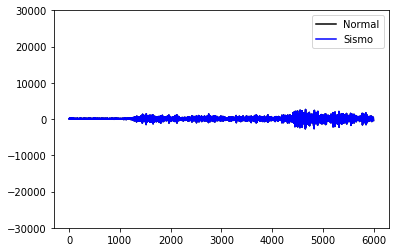

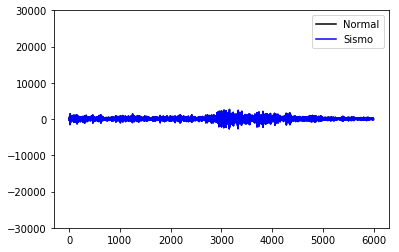

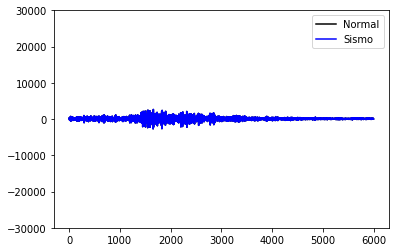

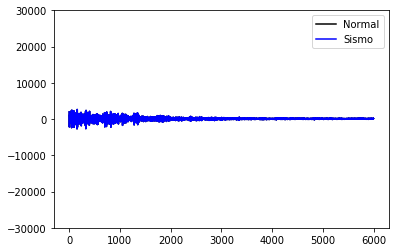

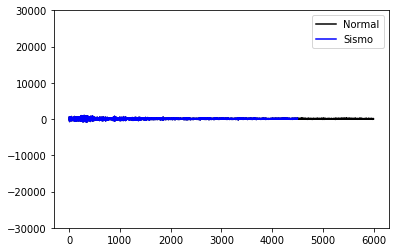

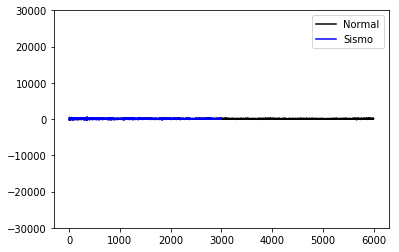

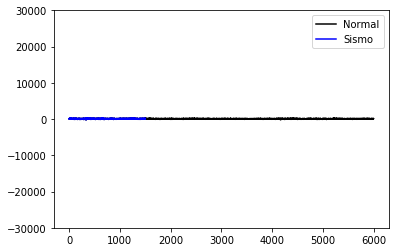

In [ ]:
label_pos = 11

# Se extraen los datos relacionados al sismo
label = ts.labels.data.iloc[label_pos]

plot_all_windows(ts, label)